In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [195]:
table = pd.read_csv("../Data/OHE_Eth.csv")
X = table.iloc[:,1:].to_numpy()
y = table["OverallPoF"].to_numpy()

In [196]:
def get_sens_spec(y,pred):
    tp = np.sum(np.logical_and(y,pred==y))
    tn = np.sum(np.logical_and(1-y,pred==y))
    fp = np.sum(np.logical_and(pred,pred!=y))
    fn = np.sum(np.logical_and(1-pred,pred!=y))
    
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    acc = (tp+tn)/(tp+tn+fp+fn)
    return [sens,spec,acc]

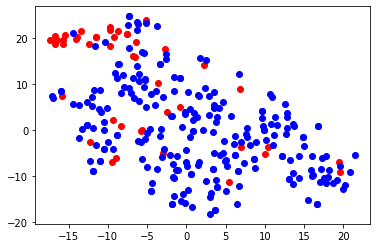

In [197]:
from sklearn.manifold import TSNE

comps = 2
perplexity = 30
early_exag = 10
learning_rate = 200
metric="euclidean"


Embed = TSNE(n_components=comps,
            perplexity=perplexity,
            early_exaggeration = early_exag,
            learning_rate=learning_rate,
            metric=metric).fit_transform(X[:,0:16])
b = y.astype(bool)
plt.scatter(Embed[b,0],Embed[b,1],c='red')
plt.scatter(Embed[True != b,0],Embed[True != b,1],c='blue')

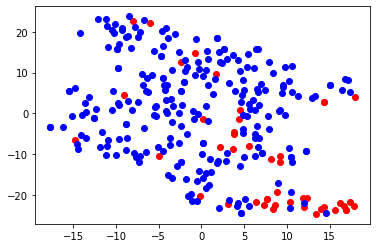

In [198]:
from sklearn.manifold import TSNE

comps = 2
perplexity = 30
early_exag = 1
learning_rate = 200
metric="euclidean"


Embed = TSNE(n_components=comps,
            perplexity=perplexity,
            early_exaggeration = early_exag,
            learning_rate=learning_rate,
            metric=metric).fit_transform(X[:,0:16])
b = y.astype(bool)
plt.scatter(Embed[b,0],Embed[b,1],c='red')
plt.scatter(Embed[True != b,0],Embed[True != b,1],c='blue')

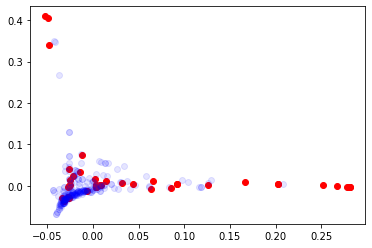

In [199]:
from sklearn.manifold import locally_linear_embedding
Embed = locally_linear_embedding(X[:,:16],n_neighbors=7,n_components=2)[0]
plt.scatter(Embed[b,0],Embed[b,1],c='red')
plt.scatter(Embed[True != b,0],Embed[True != b,1],c='blue',alpha=0.1)

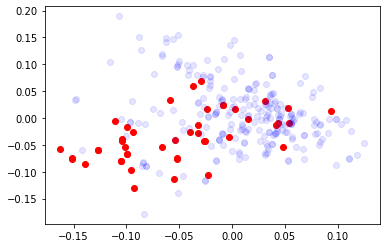

In [200]:
Embed = locally_linear_embedding(X[:,:16],n_neighbors=20,n_components=3)[0]
plt.scatter(Embed[b,0],Embed[b,1],c='red')
plt.scatter(Embed[True != b,0],Embed[True != b,1],c='blue',alpha=0.1)

In [201]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
svc = SVC(kernel='rbf',probability=True)
cross_val_score(svc,Embed,y,cv=5,scoring="f1_micro")

array([0.89473684, 0.9122807 , 0.92982456, 0.8245614 , 0.75438596])

In [202]:
from sklearn.model_selection import train_test_split
rs = 647
tr,t = train_test_split([a for a in range(X.shape[0])],train_size=0.7,random_state=rs)

In [203]:
svc.fit(Embed[tr],y[tr])
pred = svc.predict(Embed[t])
get_sens_spec(y[t],pred)

[0.5, 0.9875, 0.9534883720930233]

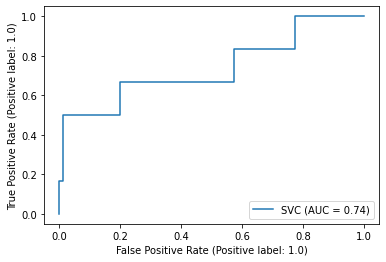

In [204]:
from sklearn.metrics import plot_roc_curve
roc = plot_roc_curve(svc,Embed[t],y[t])
fpr = roc.fpr
tpr = roc.tpr

In [205]:
np.sum(y)/y.size
def cost(sens,spec):
    PROP = 0.16
    sec = (1-sens)*PROP*30
    spc = (1-spec)*(1-PROP)
    return sec+spc

In [206]:
scores = []
for thres in np.arange(0,1,0.001):
    vs = get_sens_spec(y[t],svc.predict_proba(Embed[t])[:,0]<thres)
    scores.append([thres,cost(vs[0],vs[1]),vs[0],vs[1],vs[2]])

In [207]:
ind = np.argmin([a[1] for a in scores])
scores[ind]

[0.879, 0.651, 1.0, 0.225, 0.27906976744186046]

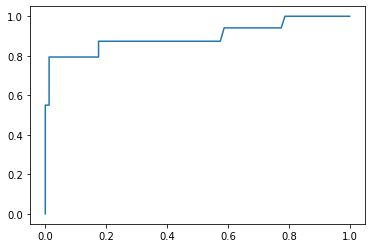

In [192]:
plt.plot(1-np.array(scores)[:,-2],np.cbrt(np.array(scores)[:,-3]))